In [64]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib import pyplot as plt

class ColoredPiGenerator(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, hidden_dim=128, num_layers=2, num_heads=8, dropout=0.1):
        super(ColoredPiGenerator, self).__init__()
        self.embedding_layer = nn.Linear(input_dim, hidden_dim)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                hidden_dim, 
                nhead=num_heads, 
                dim_feedforward=hidden_dim, 
                dropout=dropout), 
            num_layers=num_layers)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding_layer(x)

        x = self.transformer_encoder(x.unsqueeze(0))

        x = self.fc(x.squeeze(0))

        return x
    
xs = np.load('pi_xs.npy')
ys = np.load('pi_ys.npy')
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys]

# normalize pixel values to be between 0 and 1
rgb_values = rgb_values / 255.0

# concatenate x,y coordinates with RGB values
inputs = np.concatenate([xs.reshape(-1,1), ys.reshape(-1,1), rgb_values], axis=1)

Epoch 49: loss=1535.7088623046875: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 142.9801788330078, xy std: 3.12630558013916
rgb mean: 134.0154571533203, rgb std: 17.033716201782227


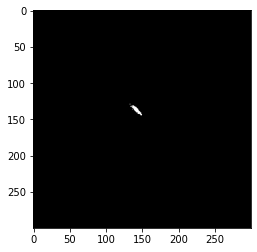

In [65]:
# Set up device   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# create model
model = ColoredPiGenerator().to(device)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# train model
batch_size = 32
num_batches = len(inputs) // batch_size
iteration = tqdm(range(50))

# Train the model for N epochs
for epoch in iteration:
    epoch_loss = 0.0
    
    # shuffle dataset
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    inputs = inputs[indices]
    
    # iterate over batches
    for i in range(num_batches):
        batch_inputs = torch.tensor(inputs[i*batch_size:(i+1)*batch_size]).float().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        # forward pass
        noise = torch.randn(batch_size, 5).to(device)
        # outputs = model(batch_inputs)
        outputs = model(noise)
        
        loss = criterion(outputs, batch_inputs)
        
        # backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    iteration.set_description(f'Epoch {epoch}: loss={loss.item()}')

# Generate some samples from the model
num_samples = 10000
generated_image = np.zeros(image_array.shape)
with torch.no_grad():
    samples = model(torch.randn(num_samples, 5).to(device))
    # samples[:, :2] = (samples[:, :2] + 1) * 149.5
    # samples[:, :2] = (samples[:, :2]) * 299

    xy = samples[:, :2].cpu().numpy()
    print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}')
    
    # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
    samples[:, 2:] = samples[:, 2:] * 255

    rgb = samples[:, 2:].cpu().numpy()
    print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}')

    samples = samples.cpu().numpy().astype(np.uint8)
    for i in range(num_samples):
        x, y, r, g, b = samples[i]
        generated_image[x, y] = [r, g, b]

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

Epoch 25/25: loss=2653.1356: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 147.23004150390625, rgb std: 0.4378741681575775
rgb mean: 19521.880859375, rgb std: 2080.105224609375


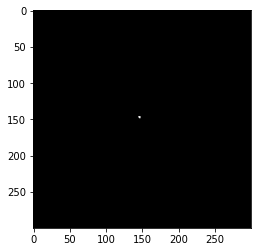

In [25]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define the model architecture using a self-attention transformer
class ColoredPiGenerator(nn.Module):
    def __init__(self, input_size=5, output_size=5, hidden_size=128, num_heads=8, num_layers=3):
        super().__init__()
        self.embed = nn.Linear(input_size, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size, 
                nhead=num_heads, 
                dim_feedforward=hidden_size*4
            ), 
            num_layers=num_layers
        )
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x.unsqueeze(0))
        x = self.output(x.squeeze(0))
        return x

# Load the data
xs = np.load('pi_xs.npy')
ys = np.load('pi_ys.npy')
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys]

# Normalize the RGB values to be between -1 and 1
rgb_values_norm = (rgb_values / 127.5) - 1

data_tensor = np.concatenate([xs.reshape(-1,1), ys.reshape(-1,1), rgb_values], axis=1)

# Create the PyTorch dataset
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(data_tensor))

# Define the dataloader
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Set up device   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the model
model = ColoredPiGenerator().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model for a few epochs
num_epochs = 25
iteration = tqdm(range(num_epochs))

for epoch in iteration:
    running_loss = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        inputs = batch[0].to(device)
        # forward pass
        noise = torch.randn(batch_size, 5).to(device)
        outputs = model(noise)
        # outputs = model(inputs)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    iteration.set_description(f'Epoch {epoch+1}/{num_epochs}: loss={epoch_loss:.4f}')

# Generate some samples from the model
num_samples = 10000
generated_image = np.zeros(image_array.shape)

with torch.no_grad():
    samples = model(torch.randn(num_samples, 5).to(device))
    # samples[:, :2] = (samples[:, :2] + 1) * 149.5
    # samples[:, :2] = (samples[:, :2]) * 299

    xy = samples[:, :2].cpu().numpy()
    print(f'xy mean: {np.mean(xy)}, rgb std: {np.std(xy)}')
    
    samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
    rgb = samples[:, 2:].cpu().numpy()
    print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}')

    samples = samples.cpu().numpy().astype(np.uint8)
    for i in range(num_samples):
        x, y, r, g, b = samples[i]
        generated_image[x, y] = [r, g, b]

# Save the output image
# Image.fromarray(image_array).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

In [26]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

# Load the dataset
xs = np.load('pi_xs.npy') # xs.shape is (5000,)
ys = np.load('pi_ys.npy') # ys.shape is (5000,)
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys] # rgb_values.shape is (5000,3)

# Normalize RGB values to the range [-1, 1]
# rgb_values = rgb_values / 255.0
# rgb_values = (rgb_values - 127.5) / 127.5
# rgb_values = (rgb_values.astype(np.float32) / 255) * 2 - 1

# Scale coordinates to the range [-1, 1]
# xs, ys = (xs - 149.5) / 149.5, (ys - 149.5) / 149.5
# xs, ys = (xs.astype(np.float32) / 299) * 2 - 1, (ys.astype(np.float32) / 299) * 2 - 1
# Normalize RGB values to the range [-1, 1]
# xs, ys = xs / 299, ys / 299

# Convert the data to PyTorch tensors
xs_tensor = torch.tensor(xs, dtype=torch.float32)
ys_tensor = torch.tensor(ys, dtype=torch.float32)
rgb_values_tensor = torch.tensor(rgb_values, dtype=torch.float32)
data_tensor = torch.stack((xs_tensor, ys_tensor, rgb_values_tensor[:, 0], rgb_values_tensor[:, 1], rgb_values_tensor[:, 2]), dim=1)
data_tensor = data_tensor.to(device)

class ColoredPiGenerator(nn.Module):
    def __init__(self):
        super(ColoredPiGenerator, self).__init__()

        self.embedding_layer = nn.Linear(5, 256)

        self.self_attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=8)

        self.feedforward_layer = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

        self.output_layer = nn.Linear(256, 5)

    def forward(self, x):
        embedded_x = self.embedding_layer(x)
        embedded_x = embedded_x.unsqueeze(0)

        attention_output, _ = self.self_attention_layer(embedded_x, embedded_x, embedded_x)
        feedforward_output = self.feedforward_layer(attention_output)
        
        output = self.output_layer(feedforward_output.squeeze(0))
        return output

# Set up device   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and the optimizer
model = ColoredPiGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
iteration = tqdm(range(num_epochs))
# Train the model for N epochs
for i in iteration:
    optimizer.zero_grad()
    # output = model(data_tensor)
    noise = torch.randn(len(xs), 5).to(device)
    output = model(noise)
    loss = nn.functional.mse_loss(output, data_tensor)
    loss.backward()
    optimizer.step()

    iteration.set_description(f'Epoch {i}: loss={loss.item()}')

Epoch 999: loss=2655.11962890625: 100%|██████████| 1000/1000 [00:08<00:00, 119.01it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 147.29074096679688, xy std: 1.025546908378601
rgb mean: 152.404052734375, rgb std: 16.4093074798584


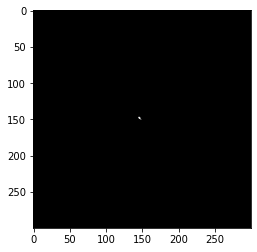

In [27]:
# Generate some samples from the model
num_samples = 10000
generated_image = np.zeros(image_array.shape)
with torch.no_grad():
    samples = model(torch.randn(num_samples, 5).to(device))
    # samples[:, :2] = (samples[:, :2] + 1) * 149.5
    # samples[:, :2] = (samples[:, :2]) * 299

    xy = samples[:, :2].cpu().numpy()
    print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}')
    
    # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
    rgb = samples[:, 2:].cpu().numpy()
    print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}')

    samples = samples.cpu().numpy().astype(np.uint8)
    for i in range(num_samples):
        x, y, r, g, b = samples[i]
        generated_image[x, y] = [r, g, b]

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image

# Load data
xs = np.load('pi_xs.npy')
ys = np.load('pi_ys.npy')
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys]

# Define dataset
class ColoredPiDataset(Dataset):
    def __init__(self, xs, ys, rgb_values):
        self.xs = xs
        self.ys = ys
        self.rgb_values = rgb_values
        
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, index):
        return torch.tensor([self.xs[index], self.ys[index], self.rgb_values[index][0], self.rgb_values[index][1], self.rgb_values[index][2]]).to(torch.float32)

dataset = ColoredPiDataset(xs, ys, rgb_values)

# Define model
class ColoredPiGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define diffusion model
        self.diffusion = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        
        # Define attention layer
        self.attention = nn.MultiheadAttention(256, 2)
        self.output_layer = nn.Linear(256, 5)
    def forward(self, x):
        # Diffusion model
        x = self.diffusion(x)

        # Attention layer
        q = k = v = x.unsqueeze(0)
        x, _ = self.attention(q, k, v)
        
        x = x.squeeze(0)
        x = self.output_layer(x)        
        return x

# Define training function
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        # outputs = model(batch)
        outputs = model(noise)
        
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up data loader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, and loss function
model = ColoredPiGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train model
num_epochs = 50
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train(model, optimizer, criterion, dataloader, device)
    # print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [50/50], Train Loss: 2679.1224: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


In [53]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Load the dataset
xs = np.load('pi_xs.npy') # xs.shape is (5000,)
ys = np.load('pi_ys.npy') # ys.shape is (5000,)
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys] # rgb_values.shape is (5000,3)

# Normalize RGB values to -1 ~ 1
rgb_values = (rgb_values.astype(np.float32) / 255) * 2 - 1

# Define dataset
class ColoredPiDataset(Dataset):
    def __init__(self, xs, ys, rgb_values):
        self.xs = xs
        self.ys = ys
        self.rgb_values = rgb_values
        
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, index):
        return torch.tensor([self.xs[index], self.ys[index], self.rgb_values[index][0], self.rgb_values[index][1], self.rgb_values[index][2]]).to(torch.float32)

dataset = ColoredPiDataset(xs, ys, rgb_values)

In [54]:
# Define model
class ColoredPiGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define diffusion model
        self.diffusion = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        
        # Define attention layer
        self.attention = nn.MultiheadAttention(256, 2)
        self.output_layer = nn.Linear(256, 5)
    def forward(self, x):
        # Diffusion model
        x = self.diffusion(x)

        # Attention layer
        q = k = v = x.unsqueeze(0)
        x, _ = self.attention(q, k, v)
        
        x = x.squeeze(0)
        x = self.output_layer(x)        
        return x

In [55]:
# Define training function
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        # outputs = model(batch)

        outputs = model(noise)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [56]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up data loader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [57]:
# Initialize model, optimizer, and loss function
model = ColoredPiGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train model
num_epochs = 50
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train(model, optimizer, criterion, dataloader, device)
    # print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [50/50], Train Loss: 1762.3648: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


xy mean: 140.4473419189453, xy std: 3.75996994972229
rgb mean: 0.3186386823654175, rgb std: 0.09607334434986115


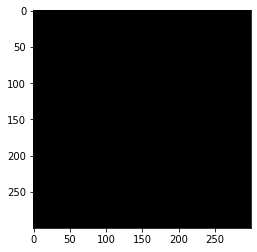

In [58]:
# Generate some samples from the model
num_samples = 10000
generated_image = np.zeros(image_array.shape)
with torch.no_grad():
    samples = model(torch.randn(num_samples, 5).to(device))
    # samples[:, :2] = (samples[:, :2] + 1) * 149.5
    # samples[:, :2] = (samples[:, :2]) * 299

    xy = samples[:, :2].cpu().numpy()
    print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}')
    
    # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
    rgb = samples[:, 2:].cpu().numpy()
    print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}')

    samples = samples.cpu().numpy().astype(np.uint8)
    for i in range(num_samples):
        x, y, r, g, b = samples[i]
        generated_image[x, y] = [r, g, b]

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

### Define the model architecture using a self-attention transformer


In [1]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

In [2]:
# # Define model
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Define diffusion model
        # self.diffusion = nn.Sequential(
        #     nn.Linear(5, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        # )
        
#         # Define attention layer
#         self.attention = nn.MultiheadAttention(256, 2)
#         self.output_layer = nn.Linear(256, 5)
#     def forward(self, x):
#         # Diffusion model
#         x = self.diffusion(x)

#         # Attention layer
#         q = k = v = x.unsqueeze(0)
#         x, _ = self.attention(q, k, v)
        
#         x = x.squeeze(0)
#         x = self.output_layer(x)        
#         return x

# Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim=5, output_dim=5, hidden_dim=256, num_layers=4, num_heads=8, dropout=0.1):
#         super(ColoredPiGenerator, self).__init__()
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )

#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 hidden_dim, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_dim * 4, 
#                 dropout=dropout), 
#             num_layers=num_layers)
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))

#         return x
    
    
# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_size=5, output_size=5, hidden_size=128, num_heads=8, num_layers=3):
#         super().__init__()
#         self.embed = nn.Linear(input_size, hidden_size)
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 d_model=hidden_size, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_size*4
#             ), 
#             num_layers=num_layers
#         )
#         self.output_layer = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.embed(x)
#         x = self.transformer(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))
#         return x

# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super(ColoredPiGenerator, self).__init__()

#         self.embedding_layer = nn.Linear(5, 256)

#         self.self_attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=8)

#         self.feedforward_layer = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256)
#         )

#         self.output_layer = nn.Linear(256, 5)

#     def forward(self, x):
#         embedded_x = self.embedding_layer(x)
#         embedded_x = embedded_x.unsqueeze(0)

#         attention_output, _ = self.self_attention_layer(embedded_x, embedded_x, embedded_x)
#         feedforward_output = self.feedforward_layer(attention_output)
        
#         output = self.output_layer(feedforward_output.squeeze(0))
#         return output

# # Define the generator model using transformer-based self-attention layers
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, num_points=5000, dim=5, dim_hidden=256, num_heads=4, num_layers=2, output_dim=5):
#         super(ColoredPiGenerator, self).__init__()
#         self.num_points = num_points
#         self.dim = dim
#         self.dim_hidden = dim_hidden
#         self.num_heads = num_heads
#         self.num_layers = num_layers
        
#         self.pos_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.query_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.value_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
        
#         nn.init.xavier_uniform_(self.pos_emb)
#         nn.init.xavier_uniform_(self.value_emb)
#         nn.init.xavier_uniform_(self.query_emb)

#         self.embedding = nn.Sequential(
#             nn.Linear(dim, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#         )
#         self.self_attns = nn.ModuleList([
#             nn.MultiheadAttention(dim_hidden, num_heads) for _ in range(num_layers)
#         ])
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, output_dim),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         # Embed the input tensor
#         x = self.embedding(x)
        
#         # Add positional embeddings to the input tensor
#         x = x.unsqueeze(0) + self.pos_emb
        
#         # Apply self-attention layers
#         for self_attn in self.self_attns:
#             x, _ = self_attn(x + self.query_emb, x + self.value_emb, x)

#         # Flatten the output tensor and apply a linear layer to produce the RGB values
#         x = x.squeeze(0).view(-1, self.dim_hidden)
#         x = self.output_layer(x)
#         return x

# # Define the generator model using transformer-based self-attention layers
# class PixelTransformer(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.num_heads = num_heads
#         self.dropout = dropout
        
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )
#         self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
#         encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#         )
        
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.decoder(x.squeeze(0))
#         return x
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x.unsqueeze(1) + self.pe[:x.size(0)]
#         return self.dropout(x).squeeze(1)
    
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.transformer = PixelTransformer(input_dim, hidden_dim, num_layers, num_heads, dropout)
#         self.decoder = nn.Linear(hidden_dim, input_dim)
        
#     def forward(self, x):
#         x = self.transformer(x)
#         x = self.decoder(x)
#         return x

# Define the model
class SelfAttentionGenerator(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, num_heads=8, hidden_dim=512, num_layers=6, batch_size=64):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, batch_size, hidden_dim))
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)])
        self.feedforward_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(0.5)
        ) for _ in range(num_layers)])
        self.out_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.layer_norm(x)
        for attn_layer, ff_layer in zip(self.attention_layers, self.feedforward_layers):
            x, _ = attn_layer(x, x, x)
            x = self.layer_norm(x)
            x = ff_layer(x)
            x = self.layer_norm(x)
        x = self.out_layer(x)
        return x.transpose(0, 1).squeeze(1)  # (batch_size, seq_len, output_dim) -> (batch_size, output_dim)

100%|██████████| 500/500 [00:00<00:00, 713.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 150.8379428421855, xy std: 7.748098483670122, xy max: 282.0133361816406, xy min: 119.49787139892578
rgb mean: 147.75914197671415, rgb std: 18.005197609337337, rgb max: 266.4501037597656, rgb min: 103.12771606445312


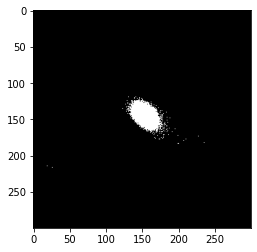

In [3]:
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)

# Define training function
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        # outputs = model(batch)
        outputs = model(noise)
        
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
hidden_dim = 256
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1
batch_size = 128
learning_rate = 1e-3
num_epochs = 50
num_samples = 500

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
# model = ColoredPiGenerator().to(device)
# model = ColoredPiGenerator(num_points=batch_size).to(device)
# model = ColoredPiGenerator(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
model = SelfAttentionGenerator(input_dim=input_dim, output_dim=input_dim, num_heads=num_heads, hidden_dim=hidden_dim, num_layers=num_layers ,batch_size=batch_size).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    
# Generate some samples from the model
sample_iter = tqdm(range(num_samples))
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((num_samples*batch_size, 2))
rgb = np.zeros((num_samples*batch_size, 3))
for sample_idx in sample_iter:
    with torch.no_grad():
        samples = model(torch.randn(batch_size, 5).to(device))

        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

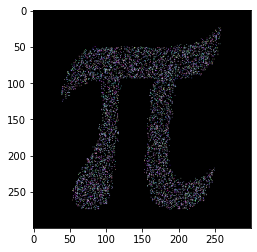

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.mixture import GaussianMixture

# Load the required data
xs = np.load('pi_xs.npy')
ys = np.load('pi_ys.npy')
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[xs, ys]
rgb_values = rgb_values.astype('float32') / 255.0

# Concatenate the x, y coordinates and RGB values
data = np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1), rgb_values], axis=1)

# Train the GMM
num_components = 1 # Number of mixture components in the GMM
gmm = GaussianMixture(n_components=num_components, covariance_type='diag')
gmm.fit(data)

# Generate new samples
num_samples = 5000 # Number of samples to generate
# z_dim = 32 # Dimension of the random noise input
# z = np.random.randn(num_samples, z_dim)
# samples = gmm.sample(z)[0]
samples = gmm.sample(num_samples)[0]

# Map the generated samples back to RGB values
generated_rgb = samples[:, 2:]
generated_rgb = np.clip(generated_rgb, 0, 1) * 255.0
generated_rgb = generated_rgb.astype('uint8')

# Visualize the generated image
generated_image = np.zeros_like(image_array)
generated_image[xs, ys] = generated_rgb
plt.imshow(generated_image, cmap='gray')
plt.show()


In [ ]:
# # Define model
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Define diffusion model
        # self.diffusion = nn.Sequential(
        #     nn.Linear(5, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        # )
        
#         # Define attention layer
#         self.attention = nn.MultiheadAttention(256, 2)
#         self.output_layer = nn.Linear(256, 5)
#     def forward(self, x):
#         # Diffusion model
#         x = self.diffusion(x)

#         # Attention layer
#         q = k = v = x.unsqueeze(0)
#         x, _ = self.attention(q, k, v)
        
#         x = x.squeeze(0)
#         x = self.output_layer(x)        
#         return x

# Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim=5, output_dim=5, hidden_dim=256, num_layers=4, num_heads=8, dropout=0.1):
#         super(ColoredPiGenerator, self).__init__()
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )

#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 hidden_dim, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_dim * 4, 
#                 dropout=dropout), 
#             num_layers=num_layers)
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))

#         return x
    
    
# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_size=5, output_size=5, hidden_size=128, num_heads=8, num_layers=3):
#         super().__init__()
#         self.embed = nn.Linear(input_size, hidden_size)
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 d_model=hidden_size, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_size*4
#             ), 
#             num_layers=num_layers
#         )
#         self.output_layer = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.embed(x)
#         x = self.transformer(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))
#         return x

# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super(ColoredPiGenerator, self).__init__()

#         self.embedding_layer = nn.Linear(5, 256)

#         self.self_attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=8)

#         self.feedforward_layer = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256)
#         )

#         self.output_layer = nn.Linear(256, 5)

#     def forward(self, x):
#         embedded_x = self.embedding_layer(x)
#         embedded_x = embedded_x.unsqueeze(0)

#         attention_output, _ = self.self_attention_layer(embedded_x, embedded_x, embedded_x)
#         feedforward_output = self.feedforward_layer(attention_output)
        
#         output = self.output_layer(feedforward_output.squeeze(0))
#         return output

# # Define the generator model using transformer-based self-attention layers
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, num_points=5000, dim=5, dim_hidden=256, num_heads=4, num_layers=2, output_dim=5):
#         super(ColoredPiGenerator, self).__init__()
#         self.num_points = num_points
#         self.dim = dim
#         self.dim_hidden = dim_hidden
#         self.num_heads = num_heads
#         self.num_layers = num_layers
        
#         self.pos_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.query_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.value_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
        
#         nn.init.xavier_uniform_(self.pos_emb)
#         nn.init.xavier_uniform_(self.value_emb)
#         nn.init.xavier_uniform_(self.query_emb)

#         self.embedding = nn.Sequential(
#             nn.Linear(dim, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#         )
#         self.self_attns = nn.ModuleList([
#             nn.MultiheadAttention(dim_hidden, num_heads) for _ in range(num_layers)
#         ])
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, output_dim),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         # Embed the input tensor
#         x = self.embedding(x)
        
#         # Add positional embeddings to the input tensor
#         x = x.unsqueeze(0) + self.pos_emb
        
#         # Apply self-attention layers
#         for self_attn in self.self_attns:
#             x, _ = self_attn(x + self.query_emb, x + self.value_emb, x)

#         # Flatten the output tensor and apply a linear layer to produce the RGB values
#         x = x.squeeze(0).view(-1, self.dim_hidden)
#         x = self.output_layer(x)
#         return x

# # Define the generator model using transformer-based self-attention layers
# class PixelTransformer(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.num_heads = num_heads
#         self.dropout = dropout
        
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )
#         self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
#         encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#         )
        
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.decoder(x.squeeze(0))
#         return x
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x.unsqueeze(1) + self.pe[:x.size(0)]
#         return self.dropout(x).squeeze(1)
    
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.transformer = PixelTransformer(input_dim, hidden_dim, num_layers, num_heads, dropout)
#         self.decoder = nn.Linear(hidden_dim, input_dim)
        
#     def forward(self, x):
#         x = self.transformer(x)
#         x = self.decoder(x)
#         return x

# Define the model
class SelfAttentionGenerator(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, num_heads=8, hidden_dim=512, num_layers=6, batch_size=64):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, batch_size, hidden_dim))
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)])
        self.feedforward_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(0.5)
        ) for _ in range(num_layers)])
        self.out_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.layer_norm(x)
        for attn_layer, ff_layer in zip(self.attention_layers, self.feedforward_layers):
            x, _ = attn_layer(x, x, x)
            x = self.layer_norm(x)
            x = ff_layer(x)
            x = self.layer_norm(x)
        x = self.out_layer(x)
        return x.transpose(0, 1).squeeze(1)  # (batch_size, seq_len, output_dim) -> (batch_size, output_dim)

In [ ]:
# # Define model
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Define diffusion model
        # self.diffusion = nn.Sequential(
        #     nn.Linear(5, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        # )
        
#         # Define attention layer
#         self.attention = nn.MultiheadAttention(256, 2)
#         self.output_layer = nn.Linear(256, 5)
#     def forward(self, x):
#         # Diffusion model
#         x = self.diffusion(x)

#         # Attention layer
#         q = k = v = x.unsqueeze(0)
#         x, _ = self.attention(q, k, v)
        
#         x = x.squeeze(0)
#         x = self.output_layer(x)        
#         return x

# Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim=5, output_dim=5, hidden_dim=256, num_layers=4, num_heads=8, dropout=0.1):
#         super(ColoredPiGenerator, self).__init__()
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )

#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 hidden_dim, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_dim * 4, 
#                 dropout=dropout), 
#             num_layers=num_layers)
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))

#         return x
    
    
# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_size=5, output_size=5, hidden_size=128, num_heads=8, num_layers=3):
#         super().__init__()
#         self.embed = nn.Linear(input_size, hidden_size)
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 d_model=hidden_size, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_size*4
#             ), 
#             num_layers=num_layers
#         )
#         self.output_layer = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.embed(x)
#         x = self.transformer(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))
#         return x

# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super(ColoredPiGenerator, self).__init__()

#         self.embedding_layer = nn.Linear(5, 256)

#         self.self_attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=8)

#         self.feedforward_layer = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256)
#         )

#         self.output_layer = nn.Linear(256, 5)

#     def forward(self, x):
#         embedded_x = self.embedding_layer(x)
#         embedded_x = embedded_x.unsqueeze(0)

#         attention_output, _ = self.self_attention_layer(embedded_x, embedded_x, embedded_x)
#         feedforward_output = self.feedforward_layer(attention_output)
        
#         output = self.output_layer(feedforward_output.squeeze(0))
#         return output

# # Define the generator model using transformer-based self-attention layers
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, num_points=5000, dim=5, dim_hidden=256, num_heads=4, num_layers=2, output_dim=5):
#         super(ColoredPiGenerator, self).__init__()
#         self.num_points = num_points
#         self.dim = dim
#         self.dim_hidden = dim_hidden
#         self.num_heads = num_heads
#         self.num_layers = num_layers
        
#         self.pos_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.query_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.value_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
        
#         nn.init.xavier_uniform_(self.pos_emb)
#         nn.init.xavier_uniform_(self.value_emb)
#         nn.init.xavier_uniform_(self.query_emb)

#         self.embedding = nn.Sequential(
#             nn.Linear(dim, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#         )
#         self.self_attns = nn.ModuleList([
#             nn.MultiheadAttention(dim_hidden, num_heads) for _ in range(num_layers)
#         ])
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, output_dim),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         # Embed the input tensor
#         x = self.embedding(x)
        
#         # Add positional embeddings to the input tensor
#         x = x.unsqueeze(0) + self.pos_emb
        
#         # Apply self-attention layers
#         for self_attn in self.self_attns:
#             x, _ = self_attn(x + self.query_emb, x + self.value_emb, x)

#         # Flatten the output tensor and apply a linear layer to produce the RGB values
#         x = x.squeeze(0).view(-1, self.dim_hidden)
#         x = self.output_layer(x)
#         return x

# # Define the generator model using transformer-based self-attention layers
# class PixelTransformer(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.num_heads = num_heads
#         self.dropout = dropout
        
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )
#         self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
#         encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#         )
        
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.decoder(x.squeeze(0))
#         return x
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x.unsqueeze(1) + self.pe[:x.size(0)]
#         return self.dropout(x).squeeze(1)
    
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.transformer = PixelTransformer(input_dim, hidden_dim, num_layers, num_heads, dropout)
#         self.decoder = nn.Linear(hidden_dim, input_dim)
        
#     def forward(self, x):
#         x = self.transformer(x)
#         x = self.decoder(x)
#         return x

# # Define the model
# class SelfAttentionGenerator(nn.Module):
#     def __init__(self, input_dim=5, output_dim=5, num_heads=8, hidden_dim=512, num_layers=6, batch_size=64):
#         super().__init__()
        
#         self.embedding = nn.Linear(input_dim, hidden_dim)
#         self.pos_embedding = nn.Parameter(torch.randn(1, batch_size, hidden_dim))
#         self.layer_norm = nn.LayerNorm(hidden_dim)
#         self.dropout = nn.Dropout(0.5)
#         self.attention_layers = nn.ModuleList([nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)])
#         self.feedforward_layers = nn.ModuleList([nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim * 4),
#             nn.GELU(),
#             nn.Linear(hidden_dim * 4, hidden_dim),
#             nn.Dropout(0.5)
#         ) for _ in range(num_layers)])
#         self.out_layer = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, x):
#         x = self.embedding(x).unsqueeze(1)
#         x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
#         x += self.pos_embedding
#         x = self.dropout(x)
#         x = self.layer_norm(x)
#         for attn_layer, ff_layer in zip(self.attention_layers, self.feedforward_layers):
#             x, _ = attn_layer(x, x, x)
#             x = self.layer_norm(x)
#             x = ff_layer(x)
#             x = self.layer_norm(x)
#         x = self.out_layer(x)
#         return x.transpose(0, 1).squeeze(1)  # (batch_size, seq_len, output_dim) -> (batch_size, output_dim)

In [ ]:
# # define the diffusion model
# class DiffusionModel(nn.Module):
#     def __init__(self, n_steps, n_heads, n_dims, n_hidden, output_dim, input_dim):
#         super().__init__()

#         self.n_steps = n_steps
#         self.n_heads = n_heads
#         self.n_dims = n_dims
#         self.n_hidden = n_hidden
#         self.empbed = nn.Linear(input_dim, n_dims)
#         self.transformer_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(n_dims, n_heads, n_hidden) 
#             for _ in range(n_steps)
#         ])

#         self.to_params = nn.Linear(n_dims, 2 * n_dims)
#         self.to_output = nn.Linear(n_dims, output_dim)

#     def sample_noise(self, batch_size, device):
#         return torch.randn(batch_size, self.n_dims, device=device)

#     def forward(self, x, timesteps_left):
#         x = self.empbed(x)
#         timesteps_left = timesteps_left.transpose(0, 1)
#         # apply the diffusion process
#         for i in reversed(range(self.n_steps)):
#             # sample noise for this step
#             noise = self.sample_noise(x.shape[0], x.device)

#             # get the parameters for this step
#             params = self.to_params(x)
#             mean, log_std = params.chunk(2, dim=-1)

#             # calculate the new state
#             std = torch.exp(log_std)
#             state = (x - mean) / std
#             state = state + noise * std
#             state = self.transformer_layers[i](state.unsqueeze(0)).squeeze(0)

#             # update x with the new state
#             x = mean + state * std
#             # apply the schedule
#             x = x * (1 - timesteps_left[i].unsqueeze(-1)) + noise * timesteps_left[i].sqrt().unsqueeze(-1)
#         # map the final state to RGB values
#         output = self.to_output(x)
#         return output